# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from DDPG_Agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import random
import time
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.14299999680370093


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
# DDPG Deep Deterministic Policy Gradient function 

def ddpg(n_episodes=500, max_t=1000, goal_score=30.0, block_episodes=100, print_every=10, train_mode=True):

    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes        : maximum number of training episodes
        max_t             : maximum number of timesteps per episode
        train_mode        : if 'True' set environment to training mode
        goal_score        : goal of the project
        block_episodes    : number of  episodes used to calculate score
        print_every       : interval to display results

    """
    mean_scores = []                               # mean scores from each episode
    min_scores = []                                # lowest scores from each episode
    max_scores = []                                # highest scores from each episode
    best_score = -np.inf                           # best score
    scores_window = deque(maxlen=block_episodes)  # mean scores from most recent episodes
    movs_avgs = []                                 # list of movements averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
        states = env_info.vector_observations                   # get the current state of agents      
        scores = np.zeros(num_agents)                           # initialize scores for agents
        agent.reset()
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select the action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get the next state
            rewards = env_info.rewards                          # get the reward
            dones = env_info.local_done                         # check if the episode is done
            
            # Reply Buffer 
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit the loop when the episode is done
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # lowest score
        max_scores.append(np.max(scores))             # highest score      
        mean_scores.append(np.mean(scores))           # episode's mean score
        scores_window.append(mean_scores[-1])         # window's mean score 
        movs_avgs.append(np.mean(scores_window))    # save movements average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} seconds)  -- \tMin: {:.1f}\tMax: {:.2f}\tMean: {:.2f}\tMov. Average: {:.2f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], movs_avgs[-1]))
        
        if train_mode and mean_scores[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
                  
        if movs_avgs[-1] >= goal_score and i_episode >= block_episodes:
            print('\nEnvironment solved in {} episodes!\tMoves Average ={:.2f} over last {} episodes'.format(\
                                    i_episode-block_episodes, movs_avgs[-1], block_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), 'actor_ckp.pth')
                torch.save(agent.critic_local.state_dict(), 'critic_ckp.pth')  
            break
            
    return mean_scores, movs_avgs

Start training

In [8]:
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
    scores, avgs = ddpg()

/Users/elisaromondia/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


KeyboardInterrupt: 

In [7]:
#in order to avoid kernel crashes
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

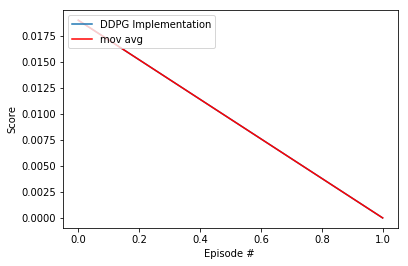

In [8]:
# Scores Plot
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG Implementation')
plt.plot(np.arange(len(scores)), avgs, c='r', label='mov avg')
plt.ylabel('Score')
plt.xlabel('Episode # ')
plt.legend(loc='upper left');
plt.show()